# Latent Dirichlet allocation

<img src="lda_img.png" alt="LDA" width="400">

*`packages`*

In [1]:
import pandas as pd
import numpy as np
import pymongo, yaml, re, string
from datetime import datetime

# nlp
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import bigrams

# gensim
from gensim.models import Word2Vec
from gensim import corpora
from gensim.models import LdaModel
from gensim.test.utils import common_texts
from pprint import pprint
from collections import Counter
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.corpora import Dictionary
import gensim.downloader as api

# scikit learn
from sklearn.decomposition import PCA

#lda model
from gensim.models import LdaModel

# matplot
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# warnings
import warnings
warnings.filterwarnings("ignore")

*Load the pre-trained Word2Vec model*

In [2]:
model_news = api.load("word2vec-google-news-300")

In [3]:
def read_yaml_file(yaml_file):
    """ load yaml cofigurations """

    config = None
    try:
        with open(yaml_file, 'r') as f:
            config = yaml.safe_load(f)
    except:
        raise FileNotFoundError('Couldnt load the file')

    return config


def get_conn_mongo(creds_file, collection):
    creds = read_yaml_file(creds_file)['mongo']
    url=creds['url']
    db=creds['db']
    collection=collection

    return url, db, collection

def clean_text(text, tokenizer, stopwords):
    text = str(text).lower()                            # lowercase words
    text = text.replace('_', ' ')                       # replace character
    text = text.replace('-', ' ')                       # replace character
    text = text.replace(',', ' ')                       # replace character
    text = text.replace('á', 'a')                       # replace character
    text = text.replace('é', 'e')                       # replace character
    text = text.replace('í', 'i')                       # replace character
    text = text.replace('ó', 'o')                       # replace character
    text = text.replace('ú', 'u')                       # replace character
    text = re.sub(r"\[(.*?)\]", "", text)               # remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)                    # remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)                  # remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)         # replace dash between words
    text = re.sub(r'(www\.|http://)', '', text)
    text = re.sub(r'\b\w*\d\w*\b', '', text)
    text = re.sub(
        f"[{re.escape(string.punctuation)}]", "", text
    )                                                   # remove punctuation

    tokens = tokenizer(text)                            # get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens] # remove digits
    tokens = [t for t in tokens if len(t) > 1]          # remove short tokens
    return tokens

*lemmatize*

In [4]:
def lemma_tokens(doc):
    lemmatizer=WordNetLemmatizer()
    docs=[lemmatizer.lemmatize(token) for token in doc]
    return docs

*get n-grams*

In [5]:
def get_ngrams(df, column):
    
    sentences_with_bigrams_list=[]
    sentences=df[column]    
    bigram_model=Phrases(sentences, min_count=20, threshold=1)  # train the model Phrases
    bigram_phraser=Phraser(bigram_model)                        # create the object Phraser
    sentences_with_bigrams=[bigram_phraser[sentence] for sentence in sentences]   # apply the ngrams to the sentences
    
    for sentence in sentences_with_bigrams:
        sentences_with_bigrams_list.append(sentence)
    return sentences_with_bigrams_list

*visualizing the words*

In [6]:
def viz_topics(list_data):
    
    # Extract unique words from your data
    unique_words = set(word for group in list_data for _, word in group[0])

    # Embed words using the pre-trained model
    word_embeddings = {}
    print('*'*50)
    for word in unique_words:        
        if word in model_news:  # Check if the word is in the model's vocabulary
            word_embeddings[word] = model_news[word]
        else:            
            print(f"Word '{word}' not in model's vocabulary.")
    print('*'*50)
    
    # ============================================================================================
    # ============================================================================================
    # Perform PCA
    pca = PCA(n_components=2)
    pca_3d = PCA(n_components=3)

    words_list = list(word_embeddings.keys())
    embeddings_matrix = np.array([word_embeddings[word] for word in words_list])

    reduced_embeddings = pca.fit_transform(embeddings_matrix)
    reduced_embeddings_3d = pca_3d.fit_transform(embeddings_matrix)
    
    # ============================================================================================
    # ============================================================================================
    # Prepare group information and create the plot (as previously described)
    group_colors = ['red', 'green', 'blue', 'black', 'yellow']  # Define colors for each group
    word_to_group = {word: [] for word in unique_words}

    for i, group in enumerate(list_data):
        for _, word in group[0]:
            word_to_group[word].append(group_colors[i])
            
    # ============================================================================================
    # ============================================================================================
    # Create the plot 2D
    plt.figure(figsize=(12, 8))
    
    for word, xy in zip(unique_words, reduced_embeddings):
        colors = word_to_group[word]
        if len(colors) > 1:
            # If the word belongs to multiple groups, create a blended color
            blended_color = np.mean([mcolors.to_rgba(color) for color in colors], axis=0)
            plt.scatter(*xy, color=blended_color, label='_nolegend_')
        else:
            plt.scatter(*xy, color=colors[0], label='_nolegend_')
        plt.text(*xy, word)

    plt.title("Word Embeddings Visualization")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()
    
    # ============================================================================================
    # ============================================================================================
    # Create the plot 3D
    word_to_group_colors = {word: [] for word in words_list}

    for i, group in enumerate(list_data):
        for _, word in group[0]:
            if word in words_list:
                word_to_group_colors[word].append(group_colors[i])

    # Function to blend colors if a word belongs to multiple groups
    def blend_colors(colors):
        return np.mean([mcolors.to_rgba(color) for color in colors], axis=0)

    # Create a 3D plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot each word
    for word, (x, y, z) in zip(words_list, reduced_embeddings_3d):
        colors = word_to_group_colors[word]
        color = blend_colors(colors) if len(colors) > 1 else colors[0]
        ax.scatter(x, y, z, color=colors[0])
        ax.text(x, y, z, word)
        
    # Set labels and title
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    ax.set_title('3D Word Embeddings Visualization')

    # Show the plot
    plt.show()

`get parameters for the connection`

*news from all sites*

In [7]:
url_mg, db_mg, collection_mg = get_conn_mongo("key.yaml", 'news')

*news from seeking alpha*

In [8]:
url_mg_sk, db_mg_sk, collection_mg_sk = get_conn_mongo("key.yaml", 'seeking_alpha')

`connection to the database`

*all sites*

In [9]:
client = pymongo.MongoClient(url_mg)
db = client[db_mg]
collection = db[collection_mg]

*seeking alpha news*

In [10]:
client_sk = pymongo.MongoClient(url_mg_sk)
db_sk = client[db_mg_sk]
collection_sk = db[collection_mg_sk]

`get the data`

*all sites*

In [11]:
data=collection.find({}) 
documents=list(data)

In [12]:
news_r=pd.DataFrame(documents)
news_r.head(2)

,_id,title,body,date,url,source,topic,summary,keywords,description,text
0,652714f40803f250cdaa13e9,"2023 Energy, Resources, and Industrials Indust...",Annual perspectives on sector trends. Our indu...,"Jan 11, 2019",https://www2.deloitte.com/us/en/pages/energy-a...,Deloitte,petroleum,[The dislocation of 2022 has fostered innovati...,,"Our energy, resources, and industrials industr...",\n \n \n \n ...
1,652714f40803f250cdaa13ea,1979: Iran and America | Brookings,"... petroleum, harmonizes with one of the earl...","Jan 24, 2019",https://www.brookings.edu/articles/1979-iran-a...,Brookings Institution,petroleum,"[Between 1973 and 1978, telephone calls betwee...",,Four decades have now passed since a mass poli...,\n\n \n \t\t\t\t\t\t\t\t\t \...


*seeking alpha*

In [13]:
data=collection_sk.find({}) 
documents_sk=list(data)

In [14]:
news_sk=pd.DataFrame(documents_sk)
news_sk.head(2)

,_id,title,body,date,url,source,topic,summary,keywords,description,text
0,65962f7aee04e419a5a73303,U.S. nat gas demand seen reaching record high ...,"<ul>\n<li>Energy analysts expect <a href=""http...",2019-01-30T21:15:39-05:00,https://seekingalpha.com/news/3427912-u-s-nat-...,Seeking Alpha,energy,"[Snowing as I exited., That was pretty crazy.,...",,Energy analysts expect record amounts of natur...,Energy\nEnergy analysts expect record amounts ...
1,65962f7aee04e419a5a73304,Alberta to ease mandatory oil production limit...,<ul>\n<li>Alberta's provincial government says...,2019-01-30T19:27:54-05:00,https://seekingalpha.com/news/3427911-alberta-...,Seeking Alpha,energy,[Saudi owns USA refinery capacity and they now...,,Alberta's provincial government says it will e...,Energy\nAlberta's provincial government says i...


`select only useful sources` 

In [15]:
source=pd.read_excel('sources.xlsx', sheet_name='source')
source.head(2)

,source
0,Deloitte
1,Offshore Technology


In [16]:
condition_source=news_r['source'].isin(list(source['source']))
news_r=news_r[condition_source]

`select only useful news` 

In [17]:
word=pd.read_excel('sources.xlsx', sheet_name='word')
word.head(2)

,words
0,oil
1,covid


In [18]:
news_r['title_lower']=news_r['title'].str.lower()

In [19]:
condition_word=news_r['title_lower'].str.contains('|'.join(word['words']), case=False, na=False)
news_r=news_r[condition_word]

`are there null values?` 

In [20]:
news_r.isnull().sum()

_id             0
title           0
body            0
date            0
url             0
source          0
topic           0
summary         1
keywords       70
description     0
text            0
title_lower     0
dtype: int64

`news by topic` 

In [21]:
news_r['topic'].value_counts()

topic
oil and gas        1061
petroleum           882
oil inventories     676
war                 567
opec                369
wti                  45
oil price            18
Name: count, dtype: int64

Numerous news articles lack summaries or detailed descriptions. <br>
Consequently, our initial analysis will prioritize the content within the body and the article title.

In [22]:
df=news_r[['title', 'body', 'summary', 'description']]
df.head(3)

,title,body,summary,description
0,"2023 Energy, Resources, and Industrials Indust...",Annual perspectives on sector trends. Our indu...,[The dislocation of 2022 has fostered innovati...,"Our energy, resources, and industrials industr..."
5,U.S. Imposes Sanctions on Venezuela's Oil Indu...,AI · Biotech · Cybersecurity · Personal Techno...,No data,No data
12,Oman Oil Minister Al Rumhi calls a bottom for ...,US Warns EU's Landmark AI Policy Will Only Ben...,[You're about to sign a deal with any is that ...,The Omani Oil Minister Mohammed Al Rumhi predi...


`define the stop words`

In [23]:
stopwords = set(stopwords.words("english")+['oil', 'petroleum', 'oil&gas', 'u'])

**`clean text`**

In [24]:
df["clean_title"]=df["title"].map(lambda x: clean_text(x, word_tokenize, stopwords))
df["clean_body"]=df["body"].map(lambda x: clean_text(x, word_tokenize, stopwords))
df.head(2)

,title,body,summary,description,clean_title,clean_body
0,"2023 Energy, Resources, and Industrials Indust...",Annual perspectives on sector trends. Our indu...,[The dislocation of 2022 has fostered innovati...,"Our energy, resources, and industrials industr...","[energy, resources, industrials, industry, out...","[annual, perspectives, sector, trends, industr..."
5,U.S. Imposes Sanctions on Venezuela's Oil Indu...,AI · Biotech · Cybersecurity · Personal Techno...,No data,No data,"[us, imposes, sanctions, venezuelas, industry]","[ai, biotech, cybersecurity, personal, technol..."


**`lemmatize the tokens`**

In [25]:
df["lemmatize_title"]=df["clean_title"].map(lambda x: lemma_tokens(x))
df["lemmatize_body"]=df["clean_body"].map(lambda x: lemma_tokens(x))
df.head(2)

,title,body,summary,description,clean_title,clean_body,lemmatize_title,lemmatize_body
0,"2023 Energy, Resources, and Industrials Indust...",Annual perspectives on sector trends. Our indu...,[The dislocation of 2022 has fostered innovati...,"Our energy, resources, and industrials industr...","[energy, resources, industrials, industry, out...","[annual, perspectives, sector, trends, industr...","[energy, resource, industrials, industry, outl...","[annual, perspective, sector, trend, industry,..."
5,U.S. Imposes Sanctions on Venezuela's Oil Indu...,AI · Biotech · Cybersecurity · Personal Techno...,No data,No data,"[us, imposes, sanctions, venezuelas, industry]","[ai, biotech, cybersecurity, personal, technol...","[u, imposes, sanction, venezuela, industry]","[ai, biotech, cybersecurity, personal, technol..."


`reset index`

In [26]:
df.reset_index(drop=True, inplace=True)

**`find n-grams`**

In [27]:
df['lemmatize_title_ngrams']=pd.DataFrame({'data':list(get_ngrams(df, 'lemmatize_title'))})
df['lemmatize_body_ngrams']=pd.DataFrame({'data':list(get_ngrams(df, 'lemmatize_body'))})

**`remove words`**

from this section we only select the column body in order to train the lda algorithm

In [28]:
docs = df['lemmatize_body_ngrams']
dictionary=Dictionary(docs)                                # create a dictionary representation of the documents
dictionary.filter_extremes(no_below=20, no_above=0.5)      # filter out words that occur less than 20 documents or more than 50% of the documents
corpus = [dictionary.doc2bow(doc) for doc in docs]         # bag of owrds representation of the documents

In [29]:
print('number of unique token: %d' % len(dictionary))
print('number of documents: %d' % len(corpus))

number of unique token: 607
number of documents: 3618


**`training model`**

In [30]:
# training parameters
num_topics=5
chunksize=2000
passes=20
iterations=400
eval_every=None        # do not evaluate model perplexity, takes too much time

temp=dictionary[0]
id2word=dictionary.id2token

model=LdaModel(corpus=corpus,
               id2word=id2word,
               chunksize=chunksize,
               alpha='auto',
               eta='auto',
               iterations=iterations,
               num_topics=num_topics,
               passes=passes,
               eval_every=eval_every)

In [31]:
top_topics=model.top_topics(corpus)
body_topics=top_topics

avg_topic_coherence=sum([t[1] for t in top_topics])/num_topics
print('avg topic coherence:%.4f' % avg_topic_coherence)

pprint(top_topics)

avg topic coherence:-5.7733
[([(0.04440504, 'u'),
   (0.03296436, 'energy'),
   (0.0307699, 'gas'),
   (0.025093874, 'opec'),
   (0.01720919, 'said'),
   (0.015263417, 'russian'),
   (0.013658602, 'market'),
   (0.013040332, 'war'),
   (0.012972328, 'natural_gas'),
   (0.011497528, 'supply'),
   (0.010475646, 'import'),
   (0.010394565, 'category'),
   (0.01018579, 'lng'),
   (0.009951272, 'crude'),
   (0.009748962, 'production'),
   (0.009670792, 'product'),
   (0.009069027, 'year'),
   (0.008972396, 'power'),
   (0.008899939, 'china'),
   (0.008517098, 'company')],
  -3.487478902684651),
 ([(0.06139074, 'u'),
   (0.026323086, 'price'),
   (0.014634246, 'reuters'),
   (0.013150276, 'russia'),
   (0.013004838, 'category'),
   (0.012045635, 'energy'),
   (0.011784868, 'crude'),
   (0.01106418, 'china'),
   (0.010764397, 'said'),
   (0.010603666, 'fuel'),
   (0.01041928, 'since'),
   (0.010200775, 'state'),
   (0.010172008, 'war'),
   (0.009614116, 'top'),
   (0.009016649, 'stock'),
   (

*`Visualizing the words related to the topics`*

**************************************************
Word 'technologycategory' not in model's vocabulary.
Word 'ai_japan' not in model's vocabulary.
Word 'trader_work' not in model's vocabulary.
Word 'power_ai' not in model's vocabulary.
Word 'hour_ago' not in model's vocabulary.
Word 'screen_display' not in model's vocabulary.
Word 'gas_sector' not in model's vocabulary.
Word 'ai_artificial' not in model's vocabulary.
**************************************************


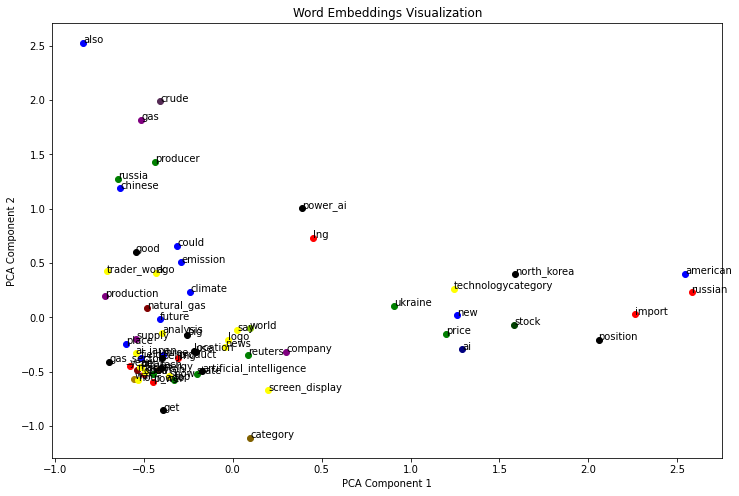

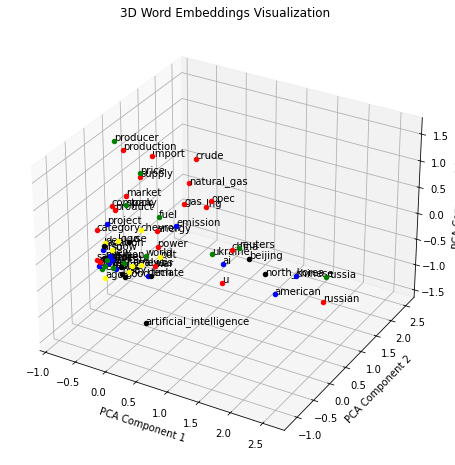

In [32]:
viz_topics(body_topics)

**`remove words`**

from this section we only select the column title in order to train the lda algorithm

In [33]:
docs = df['lemmatize_title_ngrams']
dictionary=Dictionary(docs)                                # create a dictionary representation of the documents
dictionary.filter_extremes(no_below=20, no_above=0.5)      # filter out words that occur less than 20 documents or more than 50% of the documents
corpus = [dictionary.doc2bow(doc) for doc in docs]         # bag of owrds representation of the documents

In [34]:
print('number of unique token: %d' % len(dictionary))
print('number of documents: %d' % len(corpus))

number of unique token: 209
number of documents: 3618


**`training model`**

In [35]:
# training parameters
num_topics=5
chunksize=2000
passes=20
iterations=400
eval_every=None        # do not evaluate model perplexity, takes too much time

temp=dictionary[0]
id2word=dictionary.id2token

model=LdaModel(corpus=corpus,
               id2word=id2word,
               chunksize=chunksize,
               alpha='auto',
               eta='auto',
               iterations=iterations,
               num_topics=num_topics,
               passes=passes,
               eval_every=eval_every)

In [36]:
top_topics=model.top_topics(corpus)
title_topics=top_topics

avg_topic_coherence=sum([t[1] for t in top_topics])/num_topics
print('avg topic coherence:%.4f' % avg_topic_coherence)

pprint(top_topics)

avg topic coherence:-10.9429
[([(0.08953135, 'price'),
   (0.047486033, 'u'),
   (0.04737111, 'gas'),
   (0.042312607, 'demand'),
   (0.029393636, 'record'),
   (0.023821443, 'big'),
   (0.023763854, 'fuel'),
   (0.02329105, 'company'),
   (0.023032615, 'shale'),
   (0.02266755, 'industry'),
   (0.02242419, 'high'),
   (0.022305872, 'back'),
   (0.0222275, 'gas_price'),
   (0.020352198, 'rise'),
   (0.018134959, 'profit'),
   (0.017269438, 'face'),
   (0.017230486, 'covid'),
   (0.0168614, 'opec'),
   (0.01546015, 'crude'),
   (0.015193583, 'higher')],
  -9.923913694122),
 ([(0.14098206, 'russia'),
   (0.10877722, 'energy'),
   (0.04524074, 'war'),
   (0.0432217, 'ukraine'),
   (0.039724324, 'say'),
   (0.03642065, 'opec'),
   (0.032552082, 'u'),
   (0.028312087, 'cut'),
   (0.020739572, 'exclusive'),
   (0.01961977, 'output'),
   (0.01949595, 'climate'),
   (0.018103646, 'putin'),
   (0.017755292, 'saudi'),
   (0.016798655, 'may'),
   (0.01664171, 'saudi_arabia'),
   (0.016179606, 'to

**************************************************
Word 'covid' not in model's vocabulary.
Word 'russian_gas' not in model's vocabulary.
Word 'energy_transition' not in model's vocabulary.
Word 'u_china' not in model's vocabulary.
Word 'gas_price' not in model's vocabulary.
**************************************************


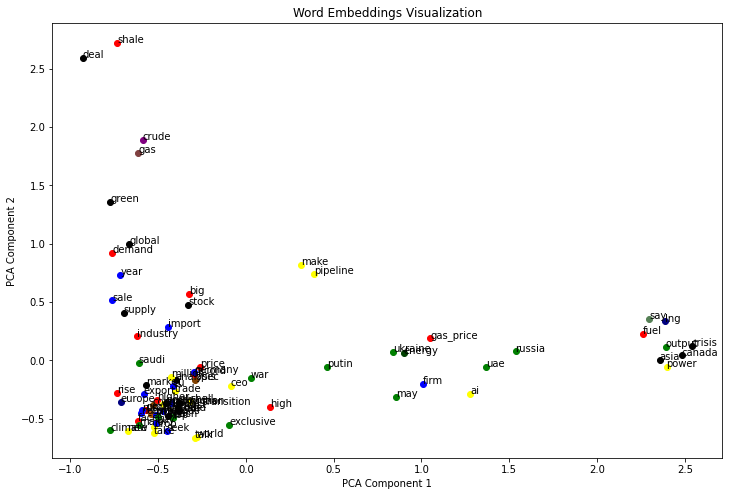

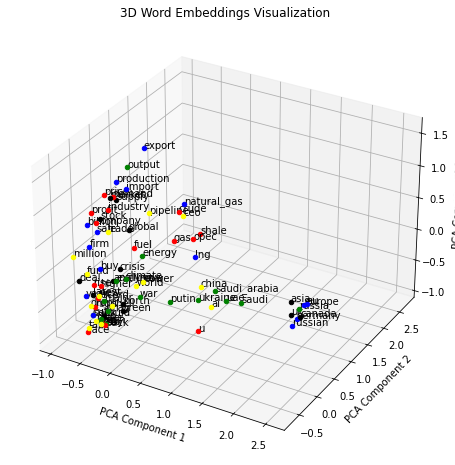

In [37]:
viz_topics(title_topics)

### `seeking alpha`

now I want to know what happened with the news from seeking alpha news

In [38]:
news_sk.head(1)

,_id,title,body,date,url,source,topic,summary,keywords,description,text
0,65962f7aee04e419a5a73303,U.S. nat gas demand seen reaching record high ...,"<ul>\n<li>Energy analysts expect <a href=""http...",2019-01-30T21:15:39-05:00,https://seekingalpha.com/news/3427912-u-s-nat-...,Seeking Alpha,energy,"[Snowing as I exited., That was pretty crazy.,...",,Energy analysts expect record amounts of natur...,Energy\nEnergy analysts expect record amounts ...


In [39]:
df_sk=news_sk[['title', 'body', 'summary', 'description']]
df_sk.head(3)

,title,body,summary,description
0,U.S. nat gas demand seen reaching record high ...,"<ul>\n<li>Energy analysts expect <a href=""http...","[Snowing as I exited., That was pretty crazy.,...",Energy analysts expect record amounts of natur...
1,Alberta to ease mandatory oil production limit...,<ul>\n<li>Alberta's provincial government says...,[Saudi owns USA refinery capacity and they now...,Alberta's provincial government says it will e...
2,Judge holds off on changing PG&E probation terms,<ul>\n<li>U.S. District Court Judge William Al...,[U.S. District Court Judge William Alsup decid...,U.S. District Court Judge William Alsup decide...


In [40]:
df_sk["clean_title"]=df_sk["title"].map(lambda x: clean_text(x, word_tokenize, stopwords))
df_sk["clean_body"]=df_sk["body"].map(lambda x: clean_text(x, word_tokenize, stopwords))
df_sk.head(2)

,title,body,summary,description,clean_title,clean_body
0,U.S. nat gas demand seen reaching record high ...,"<ul>\n<li>Energy analysts expect <a href=""http...","[Snowing as I exited., That was pretty crazy.,...",Energy analysts expect record amounts of natur...,"[us, nat, gas, demand, seen, reaching, record,...","[ul, lienergy, analysts, expect, hrefhttpsreut..."
1,Alberta to ease mandatory oil production limit...,<ul>\n<li>Alberta's provincial government says...,[Saudi owns USA refinery capacity and they now...,Alberta's provincial government says it will e...,"[alberta, ease, mandatory, production, limits,...","[ul, lialbertas, provincial, government, says,..."


In [41]:
df_sk["lemmatize_title"]=df_sk["clean_title"].map(lambda x: lemma_tokens(x))
df_sk["lemmatize_body"]=df_sk["clean_body"].map(lambda x: lemma_tokens(x))
df_sk.head(2)

,title,body,summary,description,clean_title,clean_body,lemmatize_title,lemmatize_body
0,U.S. nat gas demand seen reaching record high ...,"<ul>\n<li>Energy analysts expect <a href=""http...","[Snowing as I exited., That was pretty crazy.,...",Energy analysts expect record amounts of natur...,"[us, nat, gas, demand, seen, reaching, record,...","[ul, lienergy, analysts, expect, hrefhttpsreut...","[u, nat, gas, demand, seen, reaching, record, ...","[ul, lienergy, analyst, expect, hrefhttpsreute..."
1,Alberta to ease mandatory oil production limit...,<ul>\n<li>Alberta's provincial government says...,[Saudi owns USA refinery capacity and they now...,Alberta's provincial government says it will e...,"[alberta, ease, mandatory, production, limits,...","[ul, lialbertas, provincial, government, says,...","[alberta, ease, mandatory, production, limit, ...","[ul, lialbertas, provincial, government, say, ..."


In [42]:
df_sk.reset_index(drop=True, inplace=True)

In [43]:
df_sk['lemmatize_title_ngrams']=pd.DataFrame({'data':list(get_ngrams(df, 'lemmatize_title'))})
df_sk['lemmatize_body_ngrams']=pd.DataFrame({'data':list(get_ngrams(df, 'lemmatize_body'))})
df_sk.head(1)

,title,body,summary,description,clean_title,clean_body,lemmatize_title,lemmatize_body,lemmatize_title_ngrams,lemmatize_body_ngrams
0,U.S. nat gas demand seen reaching record high ...,"<ul>\n<li>Energy analysts expect <a href=""http...","[Snowing as I exited., That was pretty crazy.,...",Energy analysts expect record amounts of natur...,"[us, nat, gas, demand, seen, reaching, record,...","[ul, lienergy, analysts, expect, hrefhttpsreut...","[u, nat, gas, demand, seen, reaching, record, ...","[ul, lienergy, analyst, expect, hrefhttpsreute...","[energy, resource, industrials, industry, outl...","[annual, perspective, sector, trend, industry,..."


In [44]:
docs = df_sk['lemmatize_body_ngrams']
dictionary=Dictionary(docs)                                # create a dictionary representation of the documents
dictionary.filter_extremes(no_below=20, no_above=0.5)      # filter out words that occur less than 20 documents or more than 50% of the documents
corpus = [dictionary.doc2bow(doc) for doc in docs]         # bag of owrds representation of the documents

In [45]:
print('number of unique token: %d' % len(dictionary))
print('number of documents: %d' % len(corpus))

number of unique token: 324
number of documents: 2280


In [46]:
# training parameters
num_topics=5
chunksize=2000
passes=20
iterations=400
eval_every=None        # do not evaluate model perplexity, takes too much time

temp=dictionary[0]
id2word=dictionary.id2token

model=LdaModel(corpus=corpus,
               id2word=id2word,
               chunksize=chunksize,
               alpha='auto',
               eta='auto',
               iterations=iterations,
               num_topics=num_topics,
               passes=passes,
               eval_every=eval_every)

In [47]:
top_topics=model.top_topics(corpus)
seeking_body_topics=top_topics

avg_topic_coherence=sum([t[1] for t in top_topics])/num_topics
print('avg topic coherence:%.4f' % avg_topic_coherence)

pprint(top_topics)

avg topic coherence:-7.7949
[([(0.08271294, 'gas'),
   (0.06151208, 'u'),
   (0.032397125, 'energy'),
   (0.026184583, 'fuel'),
   (0.020230608, 'lng'),
   (0.017487582, 'natural_gas'),
   (0.0146949105, 'crude'),
   (0.014618628, 'europe'),
   (0.013889259, 'russian'),
   (0.01364013, 'company'),
   (0.013480092, 'power'),
   (0.011977897, 'china'),
   (0.011130506, 'project'),
   (0.011051859, 'world'),
   (0.010949565, 'market'),
   (0.010936748, 'demand'),
   (0.009978391, 'coal'),
   (0.0095351655, 'said'),
   (0.009380819, 'place'),
   (0.008755953, 'new')],
  -4.214004090845623),
 ([(0.063239425, 'u'),
   (0.03581675, 'said'),
   (0.025801178, 'market'),
   (0.02374251, 'gas'),
   (0.023343133, 'russia'),
   (0.022479117, 'would'),
   (0.022109471, 'supply'),
   (0.020736633, 'global'),
   (0.018440098, 'production'),
   (0.01829657, 'american'),
   (0.018041136, 'price'),
   (0.016970322, 'sanction'),
   (0.015787197, 'gas_company'),
   (0.014761206, 'could'),
   (0.0146456, 's

**************************************************
Word 'power_ai' not in model's vocabulary.
Word 'stagnation_remains' not in model's vocabulary.
Word 'ai_handle' not in model's vocabulary.
Word 'gas_sector' not in model's vocabulary.
Word 'ai_japan' not in model's vocabulary.
Word 'u_earnings' not in model's vocabulary.
Word 'screen_display' not in model's vocabulary.
Word 'methane_satellite' not in model's vocabulary.
Word 'energy_transition' not in model's vocabulary.
Word 'gas_company' not in model's vocabulary.
Word 'bullish_ai' not in model's vocabulary.
Word 'trader_work' not in model's vocabulary.
Word 'hour_ago' not in model's vocabulary.
Word 'data_deluge' not in model's vocabulary.
Word 'proliferate_turning' not in model's vocabulary.
**************************************************


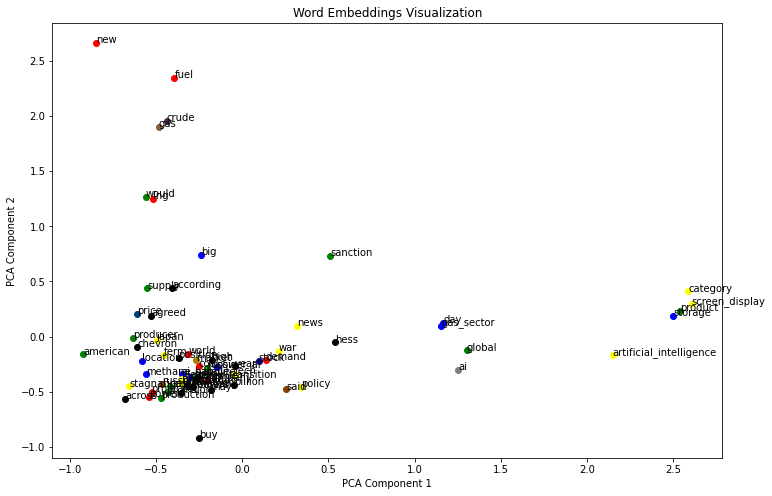

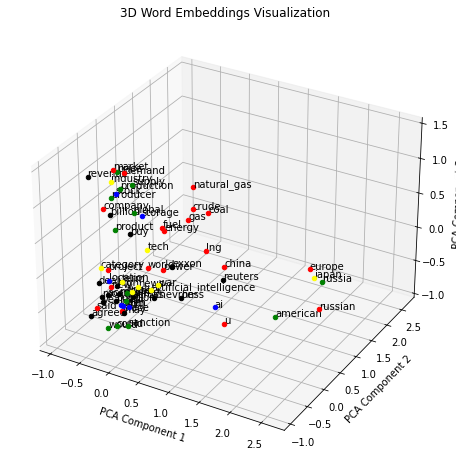

In [48]:
viz_topics(seeking_body_topics)

In [49]:
docs = df_sk['lemmatize_title_ngrams']
dictionary=Dictionary(docs)                                # create a dictionary representation of the documents
dictionary.filter_extremes(no_below=20, no_above=0.5)      # filter out words that occur less than 20 documents or more than 50% of the documents
corpus = [dictionary.doc2bow(doc) for doc in docs]         # bag of owrds representation of the documents

In [50]:
print('number of unique token: %d' % len(dictionary))
print('number of documents: %d' % len(corpus))

number of unique token: 115
number of documents: 2280


In [51]:
# training parameters
num_topics=5
chunksize=2000
passes=20
iterations=400
eval_every=None        # do not evaluate model perplexity, takes too much time

temp=dictionary[0]
id2word=dictionary.id2token

model=LdaModel(corpus=corpus,
               id2word=id2word,
               chunksize=chunksize,
               alpha='auto',
               eta='auto',
               iterations=iterations,
               num_topics=num_topics,
               passes=passes,
               eval_every=eval_every)

In [52]:
top_topics=model.top_topics(corpus)
seeking_title_topics=top_topics

avg_topic_coherence=sum([t[1] for t in top_topics])/num_topics
print('avg topic coherence:%.4f' % avg_topic_coherence)

pprint(top_topics)

avg topic coherence:-12.7225
[([(0.18478225, 'energy'),
   (0.078954615, 'u'),
   (0.052137572, 'gas_price'),
   (0.039457556, 'top'),
   (0.034201514, 'power'),
   (0.033095352, 'big'),
   (0.031275023, 'high'),
   (0.03089695, 'stock'),
   (0.030006751, 'crisis'),
   (0.028469885, 'amid'),
   (0.027747897, 'gas'),
   (0.025477001, 'fuel'),
   (0.024491867, 'production'),
   (0.024463609, 'year'),
   (0.024288291, 'plant'),
   (0.023052063, 'data'),
   (0.020040119, 'hit'),
   (0.019451896, 'record'),
   (0.018671216, 'energy_transition'),
   (0.017119344, 'plan')],
  -11.379588349270298),
 ([(0.13757066, 'russia'),
   (0.098926015, 'price'),
   (0.074190296, 'say'),
   (0.061501566, 'crude'),
   (0.05218622, 'u'),
   (0.049768843, 'company'),
   (0.047403846, 'output'),
   (0.044968788, 'opec'),
   (0.04449953, 'demand'),
   (0.036226768, 'sanction'),
   (0.026566066, 'rise'),
   (0.025046136, 'first'),
   (0.024011968, 'russian'),
   (0.021108491, 'saudi'),
   (0.019186374, 'set'),


**************************************************
Word 'covid' not in model's vocabulary.
Word 'russian_gas' not in model's vocabulary.
Word 'energy_transition' not in model's vocabulary.
Word 'u_china' not in model's vocabulary.
Word 'gas_price' not in model's vocabulary.
**************************************************


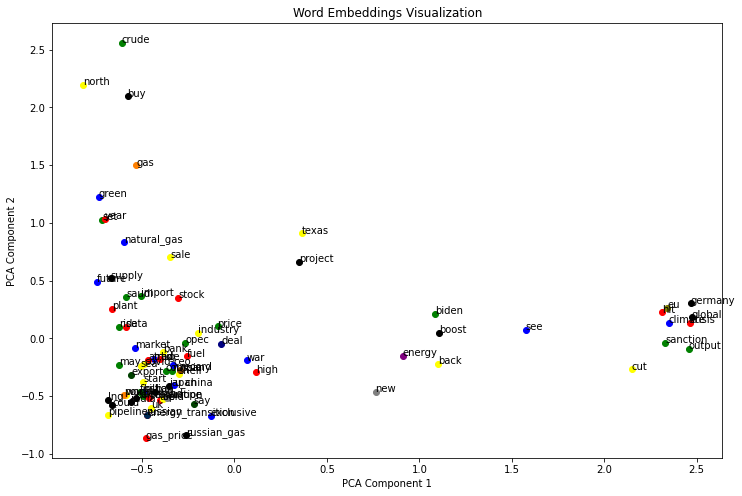

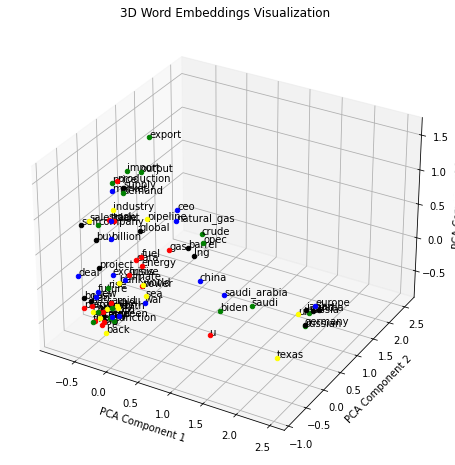

In [53]:
viz_topics(seeking_title_topics)